# 4. MLP応用
## 概要
本演習ではChapter04で学習した、深層学習の基礎である多層パーセプトロン(応用)を穴埋め形式で実装します。<br>
予め用意されたコードはそのまま使用し、指示された穴埋め部を編集してください。
演習問題文は<font color="Red">赤字</font>で表示されています。<br>
また、乱数設定により実行結果が異なるため、<font color="Red">コードを完成させたあと、必ずもう一度一番上のセルから順に最後まで実行して結果を確認してください。</font>

所要時間：5~8時間
> テーマ
>> **正則化**: MNIST<br>
>> **データ拡張**: rabbit.jpg<br>
>> [torchvision.transforms](https://pytorch.org/vision/stable/transforms.html)を利用します.<br>

### 【Google colabのみ実行】ライブラリのインストール

必要なライブラリのインストールと、実行環境のバージョンを統一します。<br>

使用するライブラリ名とバージョンは配布資料の<font color=Red>「requirements.txt」</font>で確認できます。

※以下のセルを実行しましたら、「ランタイム」→「ランタイムを再起動」により<font color=Red>再起動</font>を行ってください。

In [1]:
import sys
# Google colab環境であるか判定
if 'google.colab' in sys.modules:
    # ライブラリのインストール
    !pip install torch==1.13.0 torchvision==0.14.0
else:
    print("Not Google Colab")


Not Google Colab


### 【Google colabのみ実行】ドライブのマウント

Google Colabでは、**マウント**という作業を行って、Googleドライブ内のファイルを操作できる状態にする必要があります。<br>
<br>
以下のコードを実行してマウントしてください。なお、認証で**Googleアカウントへのログインが必要**になります。

In [2]:
import sys
# Google colab環境であるか判定
if 'google.colab' in sys.modules:
    # マウントを行う
    from google.colab import drive
    drive.mount('/content/drive')
else:
    print("Not Google Colab")


Not Google Colab


### ライブラリのインポート

必要なライブラリをインポートします。エラーになる場合は該当するものをインストールしてください。

In [3]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
import sys

device = "cuda" if torch.cuda.is_available() else "cpu"


### データの読み込み


In [4]:
root = os.path.join('~', '.torch', 'mnist')
transform = transforms.Compose([transforms.ToTensor(),
                                lambda x: x.view(-1)])
mnist_train = datasets.MNIST(root='./data',
                             download=True,
                             train=True,
                             transform=transform)
mnist_test = datasets.MNIST(root='./data',
                            download=True,
                            train=False,
                            transform=transform)

train_dataloader = DataLoader(mnist_train,
                              batch_size=100,
                              shuffle=True)
test_dataloader = DataLoader(mnist_test,
                             batch_size=100,
                             shuffle=False)


## 正則化（PyTorch）

### ドロップアウト
ドロップアウトとは、学習時に指定された割合のノードをランダムに消すテクニックであり、部分的なネットワークのアンサンブル学習として捉えることができます。これによって、表現力が高いMLPにおいても過学習を抑制することが可能になる場合あります。

ここでは、ドロップアウトのクラスをNumPyライブラリを用いて実装します。


<font color="Red">問1. 生成したrandommatrixがself.dropout_ratioより大きければTrue、そうでなければFalseを返すマスクを生成します。</font><br>



In [5]:
class Dropout():
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def __call__(self, x, train_flg=True):
        if train_flg:
            randommatrix = np.random.rand(*x.shape)
            # 問1 #### 旧シラバスコース演習3問1と同じ
            self.mask = randommatrix > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask


また、PyTorchでDropoutを実装する場合は`torch.nn.Dropout()`が用いられます。

* <font color="Red">問2. PyTorchでDropoutを実装しましょう。</font>
  * <font color="Red">問2-1. 確率 `0.5` で出力を0にするDropoutのインスタンスを生成しましょう。</font>
  * <font color="Red">問2-2. 入力`input` に対しDropoutを適用する処理を記述しましょう。</font>


In [6]:
torch.manual_seed(0)
input = torch.randn(3, 4)
print('入力: \n', input)

### 問2-1 ###
m = Dropout()
### 問2-2 ###
output = m(input)
print('Dropout後の出力: \n', output)


入力: 
 tensor([[ 1.5410, -0.2934, -2.1788,  0.5684],
        [-1.0845, -1.3986,  0.4033,  0.8380],
        [-0.7193, -0.4033, -0.5966,  0.1820]])
Dropout後の出力: 
 tensor([[ 0.0000, -0.0000, -0.0000,  0.0000],
        [-0.0000, -1.3986,  0.0000,  0.8380],
        [-0.7193, -0.0000, -0.0000,  0.1820]])


### パラメータノルムペナルティ

ノルムペナルティとは、モデルのパラメータが学習時に極端な値を取らないよう制限をかける手法です。

下記の式のように、損失関数にパラメータのLpノルム$||w||_{p}$を加えます。

$$
L_{norm}(y(X), t) = L(y(X), t) + \lambda||w||_{p}
$$

まずはLpノルム$||w||_{p}$を算出する関数を実装しましょう。また、以下ではテンソルに対するnumpyを用いた演算はエラーが生じる可能性がありますのでtorchを用いた演算を使いましょう。

* <font color="Red">問3. Lpノルムを算出する関数を完成させてください。</font>

In [7]:
def lp_norm(w, p=2):
    # 問3 ###
    return (torch.sum(torch.abs(w)**p))**(1 / p)


次に、ラッソの損失を算出する関数を実装しましょう。

ラッソの損失はL1ノルムを用いて、下記の式のように定義されます。

$$
L_{norm}(y(X), t) = L(y(X), t) + \lambda\sum_{n=1}^D{|{w_n}|}
$$

* <font color="Red">問4. L1ノルム付き損失関数の</font> $\lambda\sum_{n=1}^D{|w_n|}$ <font color="red">を算出する関数を完成させてください。</font>

In [8]:
def Lasso_loss(net, lam=0.001):
    loss = 0
    for params in net.parameters():  # net.parameters()はネットワークの各層のパラメータを意味する
        ### 問4 ###
        loss += torch.sum(torch.abs(params))
    return lam * loss


次に、リッジの損失を算出する関数を実装しましょう。

L2ノルム付き損失関数はL2ノルムを用いて、下記の式のように定義されます。

$$
L_{norm}(y(X), t) = L(y(X), t) + \frac{\lambda}{2}{\sum_{n=1}^D{w_n^2}}
$$

* <font color="Red">問5.  L2ノルム付き損失関数の</font> $\frac{\lambda}{2} \sum_{n=1}^D{w_n^2}$ <font color="red">を算出する関数を完成させてください。</font>

In [9]:
def Ridge_loss(net, lam=0.001):
    loss = 0
    for params in net.parameters():  # net.parameters()はネットワークの各層のパラメータを意味する
        ### 問5 ###
        loss += torch.sum(torch.abs(params))
    return (1/2) * lam * loss


## ドロップアウトとL2ノルム正則化を含めたMLPの実装 (<u>ライブラリを使用しない</u>)

### 線形結合層などの定義

chapter02,chapter03演習のコードをpytorchを用いて実装しているものであり、読み飛ばしていただいて構いません。

In [10]:
# nn.Linearではなく、スクラッチの際に使用
class FullyConnectedLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FullyConnectedLayer, self).__init__()
        self.in_features = input_dim  # 入力値の次元
        self.out_features = output_dim  # 出力値の次元

        weight = torch.randn(input_dim, output_dim) * 0.01
        bias = torch.randn(output_dim) * 0.01

        self.weight = nn.parameter.Parameter(weight)
        self.bias = nn.parameter.Parameter(bias)

    def forward(self, x):
        x = torch.mm(x, self.weight) + self.bias
        return x


In [11]:
# nn.ReLUではなく、スクラッチの際に使用
class ReLU(nn.Module):
    def __init__(self):
        super(ReLU, self).__init__()

    def forward(self, x):
        mask = (x <= 0)
        x[mask] = 0
        return x


ドロップアウトを含めたMLPクラスを実装します。<br>
今回構築するモデルのアーキテクチャは以下のようになっています。<br>

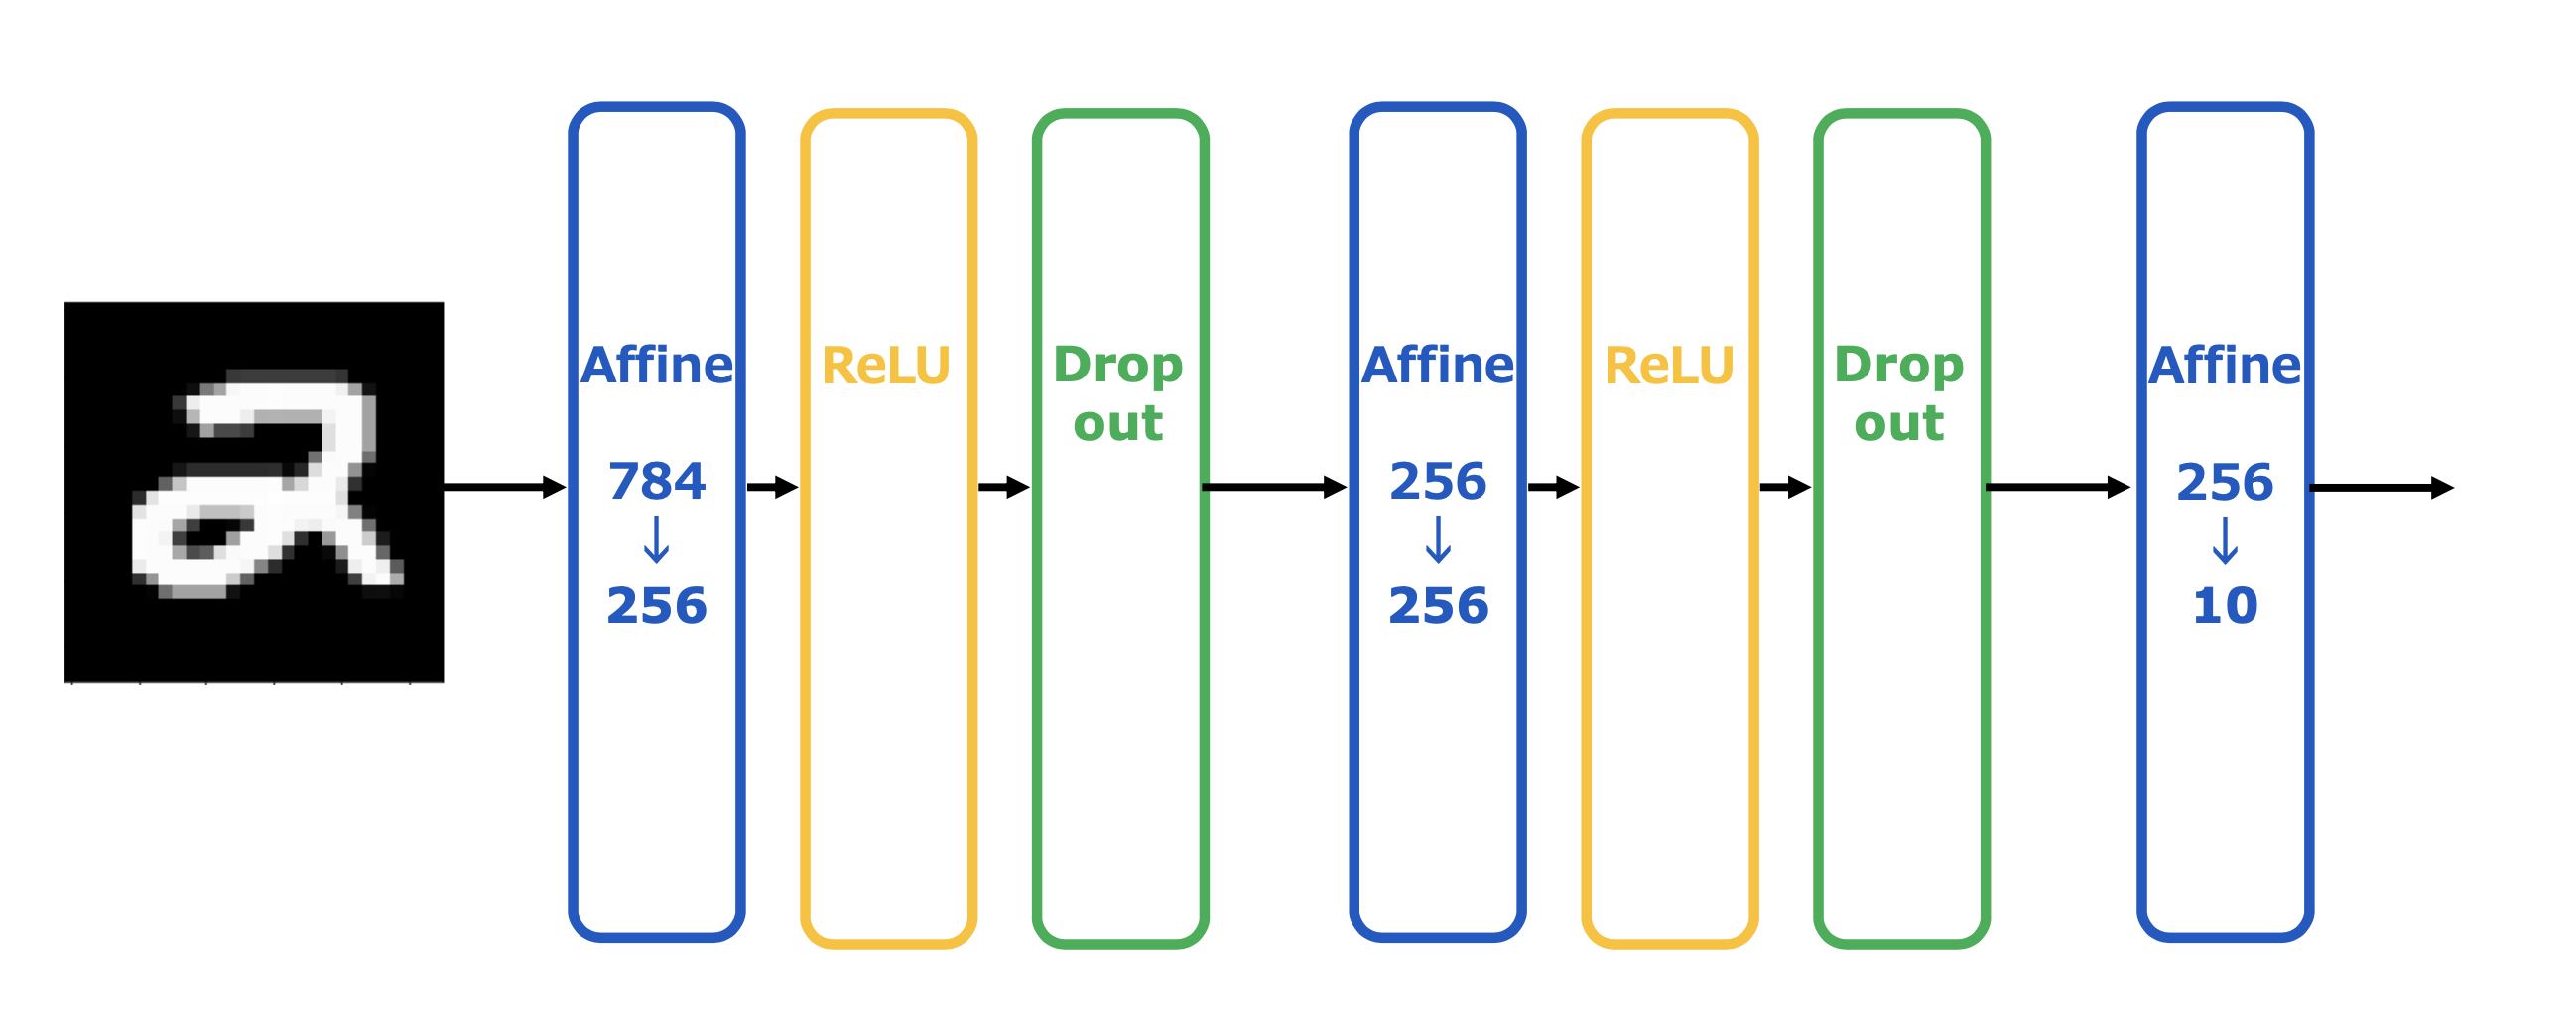

* <font color="Red">問6.ドロップアウトを含めたMLPクラスを完成させてください。</font><br>
    * <font color="Red">問6-1. 【forward関数】第1の全結合層の出力に対してドロップアウトを適用する処理を記述しましょう。</font><br>
    * <font color="Red">問6-2. 【forward関数】第2の全結合層の出力に対してドロップアウトを適用する処理を記述しましょう。</font><br>

In [12]:
class MLP_classifier(nn.Module):
    def __init__(self):
        '''
        構造
        x -> fc(784, 256) -> relu -> dropout -> fc(256, 256) -> relu -> dropout -> fc(256, 10) -> x
        '''
        super(MLP_classifier, self).__init__()
        # 層の定義
        self.fc1 = nn.Linear(784, 256)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout()
        self.fc2 = nn.Linear(256, 256)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout()
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        '''
        順伝播
        '''
        x = self.relu1(self.fc1(x))
        ### 問6-1 ###
        x = self.dropout1(x)
        x = self.relu2(self.fc2(x))
        ### 問6-2 ###
        x = self.dropout2(x)
        x = self.fc3(x)

        return x


### 学習
始めに、モデルや損失関数、最適化アルゴリズムを定義します。

* <font color="Red">問7. 問5で実装した`Ridge_loss`を使用して、損失関数に正則化項$\frac{\lambda}{2}{\sum_{n=1}^D{w_n^2}}$を加えましょう。</font>

また、学習ステップとテストステップの手順を関数化します。

In [13]:
# モデルの宣言
model = MLP_classifier()
model.to(device)
# クロスエントロピー(損失関数)を定義
criterion = nn.CrossEntropyLoss()
# 最適化アルゴリズム
optimizer = torch.optim.Adam(model.parameters())


def compute_loss(y, t, criterion=criterion):
    #### 問7 ###
    loss = criterion(y, t) + Ridge_loss(model)
    return loss


def train_step(x, t, model, optimizer):
    model.train()
    preds = model(x)
    loss = compute_loss(preds, t)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss, preds


def test_step(x, t, model):
    model.eval()
    preds = model(x)
    loss = compute_loss(preds, t)
    return loss, preds


最後に学習ステップ`train_step`、テストステップ`test_step`を用いて学習と評価を行います。

accuracyが95%前後になっていれば学習成功です。

In [14]:
# 学習エポック数
epochs = 15
# epochs繰り返す
for epoch in range(epochs):

    train_loss = 0.
    test_loss = 0.
    train_acc = 0.
    test_acc = 0.

    for imgs, labels in train_dataloader:
        imgs, labels = imgs.to(device), labels.to(device)
        loss, preds = train_step(imgs, labels, model, optimizer)
        train_loss += loss.item()
        train_acc += torch.sum(torch.argmax(preds, axis=1) == labels)
    train_loss /= len(train_dataloader)
    train_acc /= len(mnist_train)

    for imgs, labels in test_dataloader:
        imgs, labels = imgs.to(device), labels.to(device)
        loss, preds = test_step(imgs, labels, model)
        test_loss += loss.item()
        test_acc += torch.sum(torch.argmax(preds, axis=1) == labels)
    test_loss /= len(test_dataloader)
    test_acc /= len(mnist_test)

    print(f'epoch: {epoch+1},train loss: {train_loss:.5f}, train acc: {train_acc:.5f}, test loss: {test_loss:.5f}, test acc: {test_acc:.5f}')


epoch: 1,train loss: 1.42802, train acc: 0.81147, test loss: 0.95831, test acc: 0.91150
epoch: 2,train loss: 1.03347, train acc: 0.87725, test loss: 0.83700, test acc: 0.93230
epoch: 3,train loss: 0.96165, train acc: 0.88923, test loss: 0.79326, test acc: 0.93280
epoch: 4,train loss: 0.92400, train acc: 0.89497, test loss: 0.75629, test acc: 0.94210
epoch: 5,train loss: 0.89722, train acc: 0.89855, test loss: 0.72665, test acc: 0.94660
epoch: 6,train loss: 0.87776, train acc: 0.90085, test loss: 0.71861, test acc: 0.94700
epoch: 7,train loss: 0.86395, train acc: 0.90310, test loss: 0.70012, test acc: 0.94950
epoch: 8,train loss: 0.85263, train acc: 0.90475, test loss: 0.69008, test acc: 0.95040
epoch: 9,train loss: 0.84575, train acc: 0.90438, test loss: 0.68908, test acc: 0.95250
epoch: 10,train loss: 0.83744, train acc: 0.90623, test loss: 0.68673, test acc: 0.95120
epoch: 11,train loss: 0.83613, train acc: 0.90607, test loss: 0.67602, test acc: 0.95020
epoch: 12,train loss: 0.82722,

## データ拡張（PyTorch）

始めに`rabbit.jpg`の画像を読み込み、表示しましょう。

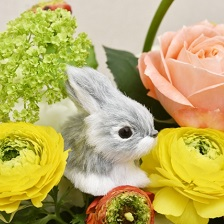

In [15]:
# Google colab環境であるか判定
if 'google.colab' in sys.modules:
    # マイドライブ内のデータを読み込むpathに設定
    img_path = '/content/drive/MyDrive/rabbit.jpg'
else:
    img_path = 'rabbit.jpg'

img = Image.open(img_path)
display(img)


### Random Flip

Random Flipは画像を反転させるデータ拡張方法です。ここでは、`RandomHorizontalFlip`と`RandomVerticalFlip`を実装します。

`RandomHorizontalFlip`は水平方向に確率`p`に従って反転させます。

`RandomVerticalFlip`は垂直方向に確率`p`に従って反転させます。

`RandomHorizontalFlip`や`RandomVerticalFlip`は以下のような引数を持ちます。

```
【引数】
  p : 画像を反転させる確率 (ex. p=0.5)
```

分かりやすさのため、ここでは確率を1として必ず反転した画像を出力します。
* <font color="Red">問8-1. `transforms.RandomHorizontalFlip`を用いて、水平方向に確率`p=1`で反転させるデータ拡張を加えてください。</font>
* <font color="Red">問8-2. `transforms.RandomVerticalFlip`を用いて、垂直方向に確率`p=1`で反転させるデータ拡張を加えてください。</font>


なお、エラーが出る場合は「rabbit.jpg」のファイルパスを確認してください。

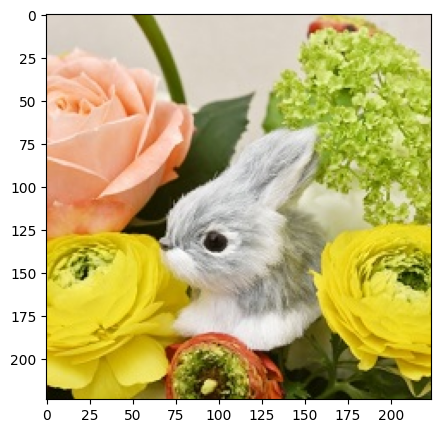

In [16]:
img = Image.open(img_path)
transform = transforms.Compose([
    transforms.ToTensor(),
    ### 問8-1 ###
    transforms.RandomHorizontalFlip(p=1.0)
])
img = transform(img)
img = img.numpy().reshape((3, 224, 224))
img = np.transpose(img, (1, 2, 0))

plt.figure(figsize=(5, 5))
plt.imshow(img)


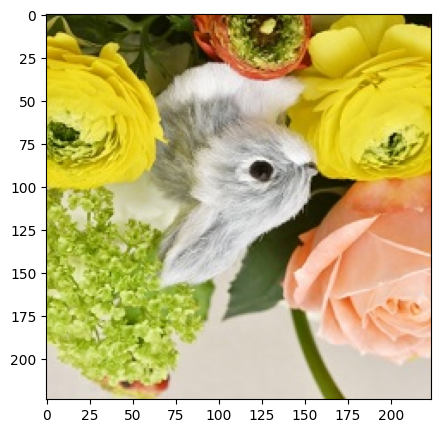

In [17]:
img = Image.open(img_path)
transform = transforms.Compose([
    transforms.ToTensor(),
    ### 問8-2 ###
    transforms.RandomVerticalFlip(p=1.0)
])
img = transform(img)
img = img.numpy().reshape((3, 224, 224))
img = np.transpose(img, (1, 2, 0))

plt.figure(figsize=(5, 5))
plt.imshow(img)


### Erase

Eraseの中でも、`RandomErasing`を実装します。`RandomErasing`は画像の中の長方形領域をランダムに選択しそのピクセルを消去させるデータ拡張方法です。

`RandomErasing`は以下のような引数を持ちます。

```
【引数】
  p : 画像の一部を消去させる確率 (ex. p=0.5)
  scale : 入力画像に対する消去領域の比率の範囲 (ex. scale=(0.05, 0.06))
  ratio : 消去領域のアスペクト比の範囲 (ex. ratio=(0.3, 3.0))
  value : 消去に関するパラメータで、RGBチャンネルをそれぞれ消去する際は、長さ3のタプルを指定 (ex. value=0)
```

分かりやすさのため、ここでは確率を1として必ずある一部分が消去された画像を出力します。

* <font color="Red">問9. `transforms.RandomErasing`を用いて、確率`p=1`で画像内の長方形領域をランダムにピクセル消去させるデータ拡張を加えてください。ただし、以下の条件を満たしてください。</font>
  * <font color="Red">入力画像に対する消去領域の比率の範囲を(0.02, 0.33)とします。</font>
  * <font color="Red">消去領域のアスペクト比の範囲を(0.3, 3.3)とします。</font>
  * <font color="Red">消去領域の色は黒(=0)とします。</font>

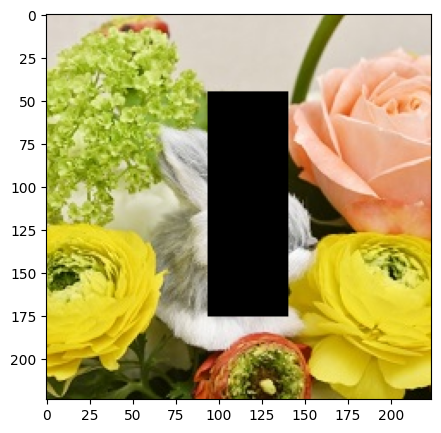

In [18]:
img = Image.open(img_path)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomErasing(p=1, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0)
    ### 問9 ###
])
img = transform(img)
img = img.numpy().reshape((3, 224, 224))
img = np.transpose(img, (1, 2, 0))

plt.figure(figsize=(5, 5))
plt.imshow(img)


### Crop

Cropsは画像の切り取りによって得られるデータ拡張方法です。Cropsの中でも、`CenterCrop`を実装します。`CenterCrop`は与えられた画像を中央で切り取ります。

`CenterCrop`は以下のような引数を持ちます。

```
【引数】
  size : 切り取るサイズ (ex. size=300, size=(200, 300))
```

* <font color="Red">問10. `transforms.CenterCrop`を用いて、画像の中央を(224, 224)のサイズで切り取るデータ拡張を加えてください。</font>

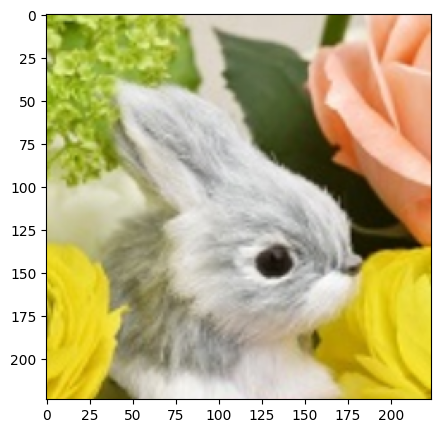

In [19]:
img = Image.open(img_path)
transform = transforms.Compose(
    [transforms.Resize(350),
     ### 問10 ###
     transforms.CenterCrop(224),
     transforms.ToTensor()
     ]
)
img = transform(img)
img = img.numpy().reshape((3, 224, 224))
img = np.transpose(img, (1, 2, 0))

plt.figure(figsize=(5, 5))
plt.imshow(img)


### Brightness

Brightnessは画像の明るさを変更させることによって得られるデータ拡張方法です。Brightnessの中でも、`ColorJitter`を実装します。`ColorJitter`は画像の明るさ、コントラスト、彩度、色合いをランダムに変化させます。<br>

`ColorJitter`は以下のような引数を持ちます。

```
【引数】
  brightness : 明るさを調整するパラメータ (ex. brightness=0.80)
  contrast : コントラストを調整するパラメータ (ex. contrast=0.80)
  saturation : 彩度を調整するパラメータ (ex. saturation=0.80)
  hue : 色合いを調整するパラメータ (ex. hue=0.60)
```

* <font color="Red">問11. `transforms.ColorJitter`を用いて、画像の明るさを変更させるデータ拡張を加えましょう。ただし、以下の条件を満たしてください。</font>
  * <font color="Red">明るさを0.75とします</font>
  * <font color="Red">コントラストを0.75とします</font>
  * <font color="Red">彩度を0.75とします</font>
  * <font color="Red">色合いを0.5とします</font>

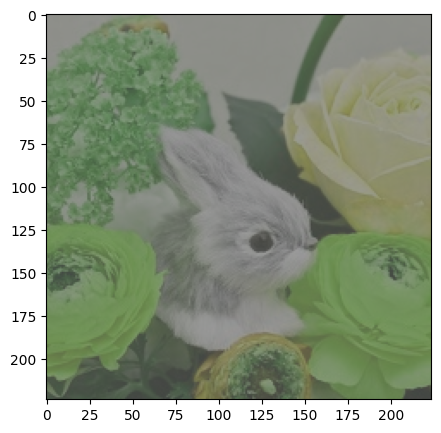

In [20]:
img = Image.open(img_path)
transform = transforms.Compose([
    transforms.ToTensor(),
    ### 問11 ###
    transforms.ColorJitter(brightness=0.75, contrast=0.75, saturation=0.75, hue=0.5)
])
img = transform(img)
img = img.numpy().reshape((3, 224, 224))
img = np.transpose(img, (1, 2, 0))

plt.figure(figsize=(5, 5))
plt.imshow(img)


### Rotate

Rotateは画像を回転させることによって得られるデータ拡張方法です。Rotateの中でも、`RandomRotation`を実装します。`RandomRotation`はランダムに画像を回転させます。

`RandomRotation`は以下のような引数を持ちます。

```
【引数】
  degrees : 選択する角度の範囲を指定するパラメータ (ex. degrees=60)
  expand : 拡張を実行するか決定するパラメータ。
           trueの場合、出力を拡大して、回転した画像全体を格納できる大きさにし、
           falseまたは省略された場合は、出力画像を入力画像と同じ大きさにする。
  fill : 回転した画像の外側の領域を埋める値 (ex. fill=255)
```

* <font color="Red">問12. `transforms.RandomRotation`を用いて、画像を-90~90度回転させるデータ拡張を加えましょう。回転した画像の外側は黒色(=0)とし、出力画像は入力画像と同じ大きさにします。</font>

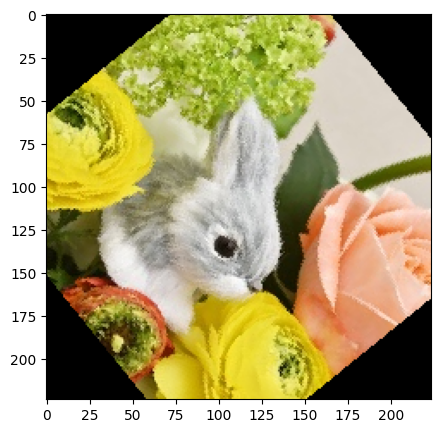

In [21]:
img = Image.open(img_path)
transform = transforms.Compose([
    transforms.ToTensor(),
    ### 問12 ###
    transforms.RandomRotation(degrees=90, expand=False, fill=0)
])
img = transform(img)
img = img.numpy().reshape((3, 224, 224))
img = np.transpose(img, (1, 2, 0))

plt.figure(figsize=(5, 5))
plt.imshow(img)


### MixUp

MixUpは2つの学習サンプルを混合して新たな学習サンプルを作成するデータ拡張手法です。

データとラベルのペア$(X_1, y_1)$と$(X_2, y_2)$から新たな学習サンプル$(X, y)$を作成します。ラベル$y_1, y_2$がone-hot表現の時、以下の式で$(X, y)$を作成します。

$$
X = \lambda X_1 + (1 - \lambda)X_2
$$
$$
y = \lambda y_1 + (1 - \lambda)y_2
$$

ここで、$\lambda$は0~1の範囲を取るパラメータで、ベータ分布$\beta(x,\alpha, \alpha)$からランダムにサンプリングします。$\alpha$はハイパーパラメータです。<br>
ベータ分布は以下のような確率密度関数として表すことができる。$C$は正規化定数。
$$
\beta(x,a,b) = C x ^ {a-1}(1-x) ^ {b-1}(0\leqq x\leqq 1)
$$


* <font color="Red">問13. MixUpにより新たな学習サンプルを作成しましょう。</font>
  * <font color="Red">問13-1. `np.random.beta()`関数を用いてベータ分布$\beta(\alpha, \alpha)$からサンプリングしましょう。</font>
  * <font color="Red">問13-2. パラメータ`lam`, 学習サンプル`x`, `x[index,:]`を使用して新たな学習データを算出する式を記述してください。</font>

In [22]:
torch.manual_seed(0)
np.random.seed(0)
transform = transforms.Compose([
    transforms.ToTensor(),
])
dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)


def mixup_data(x, y, alpha=1.0, use_cuda=True):
    '''Compute the mixup data. Return mixed inputs, pairs of targets, and lambda'''
    if alpha > 0.:
        ### 問13-1 ###
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.
    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    ### 問13-2 ###
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


target_a : 7
target_b : 6
mixed_target_vector: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6294, 0.3706, 0.0000,
        0.0000])
lambda : 0.37061547061658573


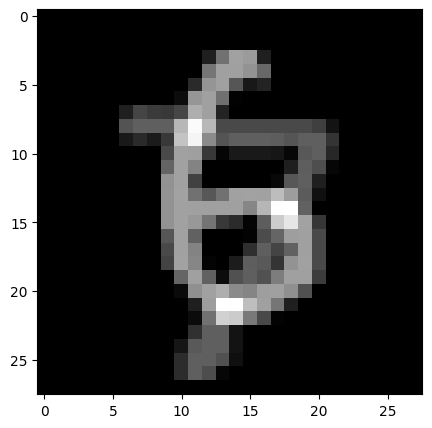

target_a : 3
target_b : 4
mixed_target_vector: tensor([0.0000, 0.0000, 0.0000, 0.5503, 0.4497, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000])
lambda : 0.5503058575303685


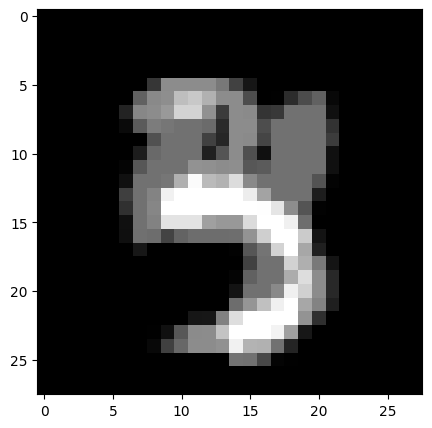

target_a : 7
target_b : 3
mixed_target_vector: tensor([0.0000, 0.0000, 0.0000, 0.6992, 0.0000, 0.0000, 0.0000, 0.3008, 0.0000,
        0.0000])
lambda : 0.30081220227043654


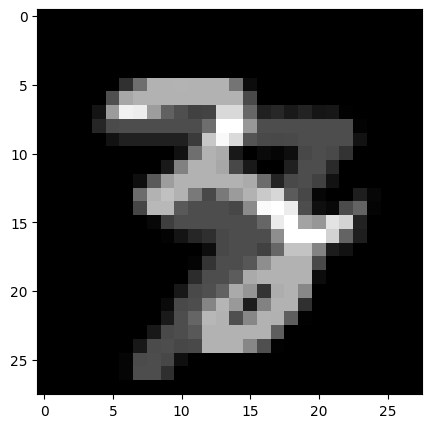

In [23]:
counter = 0
for data, label in dataloader:
    mixed_data, target_a, target_b, lam = mixup_data(data, label, alpha=0.5, use_cuda=torch.cuda.is_available())
    counter += 1
    print(f'target_a : {target_a[0]}')
    print(f'target_b : {target_b[0]}')
    onehot_target_a = torch.eye(10)[target_a]
    onehot_target_b = torch.eye(10)[target_b]
    mixed_target_vector = onehot_target_a * lam + onehot_target_b * (1-lam)
    print(f'mixed_target_vector: {mixed_target_vector[0]}')
    print(f'lambda : {lam}')
    img = mixed_data.numpy()[0].reshape((28, 28))
    plt.figure(figsize=(5, 5))
    plt.imshow(img, cmap='gray')
    plt.show()
    if counter == 3:
        break
